
🧠 Testing Doc2Vec field: title
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


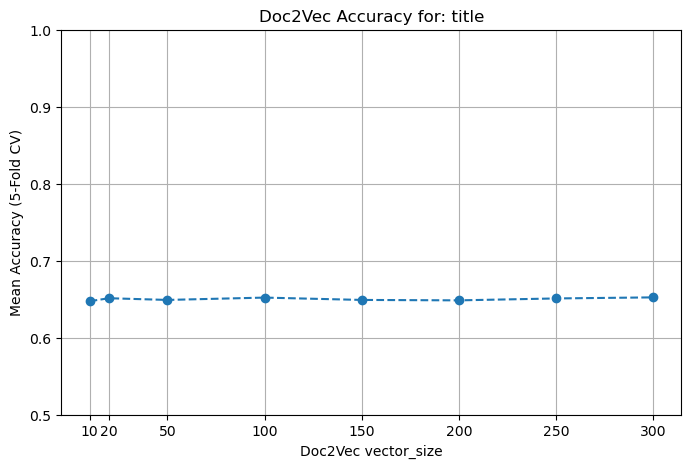


🧠 Testing Doc2Vec field: title+abstract
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


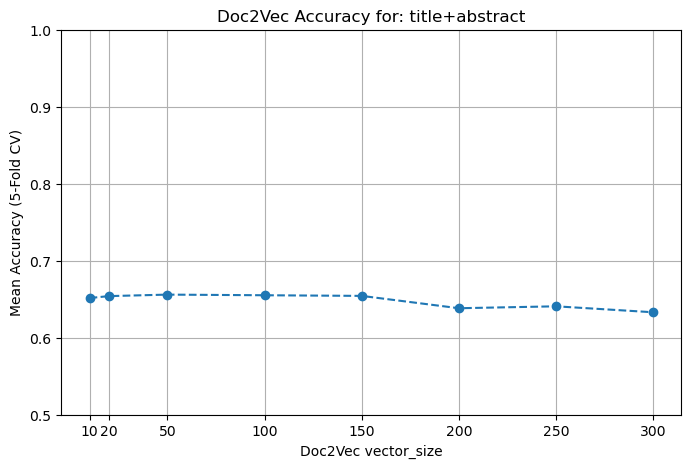


🧠 Testing Doc2Vec field: title+abstract+introduction
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


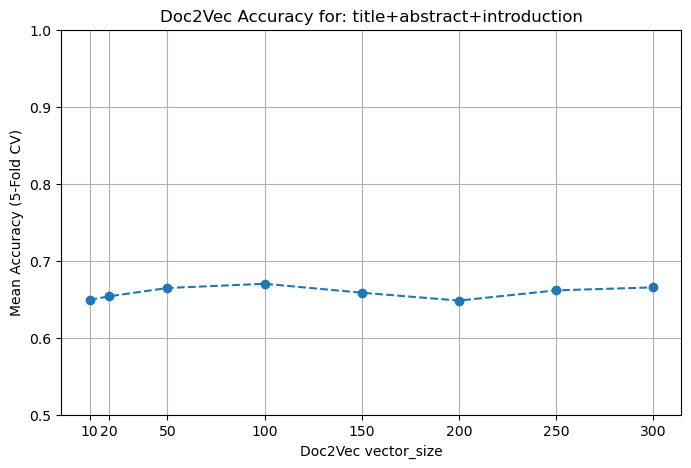


🧠 Testing Doc2Vec field: title+abstract+introduction+conclusion
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


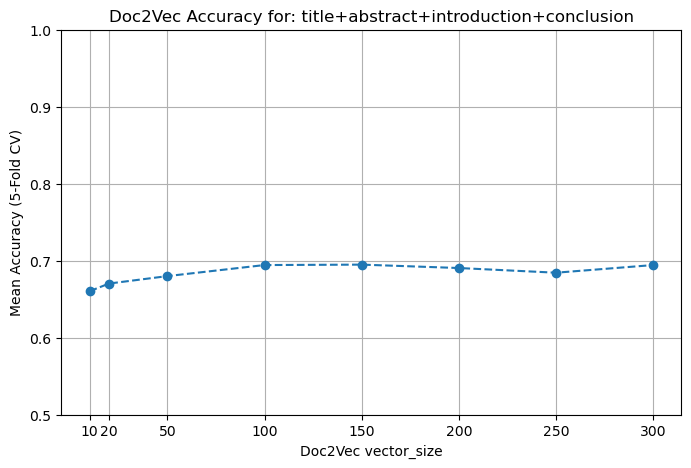


🧠 Testing Doc2Vec field: title+abstract+conclusion
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


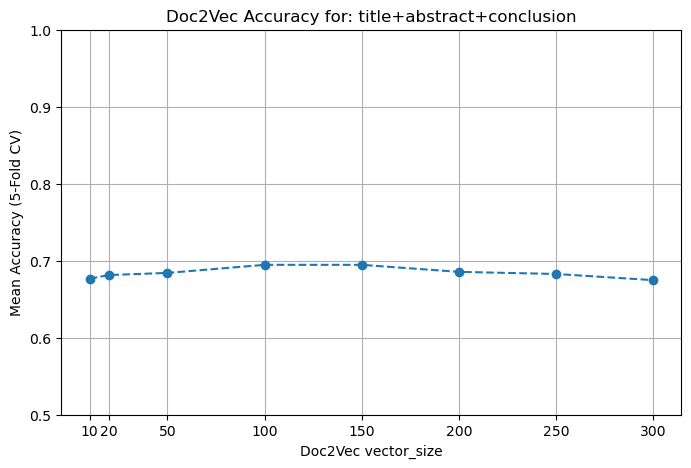


🧠 Testing Doc2Vec field: title+introduction+conclusion
🔸 vector_size = 10
🔸 vector_size = 20
🔸 vector_size = 50
🔸 vector_size = 100
🔸 vector_size = 150
🔸 vector_size = 200
🔸 vector_size = 250
🔸 vector_size = 300


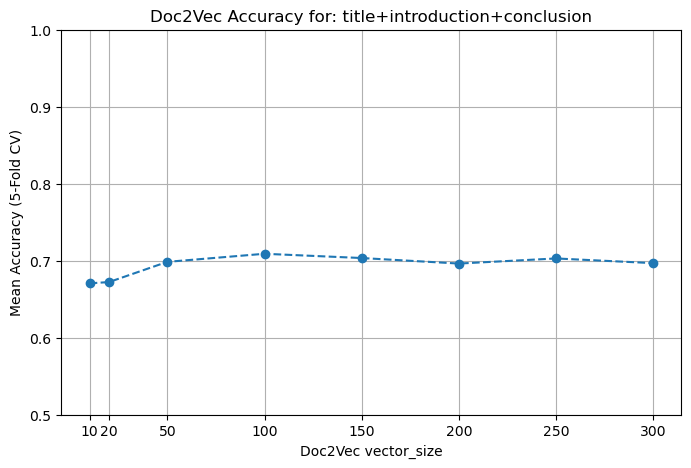


📊 Doc2Vec 全部字段组合下的准确率:

📘 title:
  vector_size=10: Accuracy=0.6472
  vector_size=20: Accuracy=0.6511
  vector_size=50: Accuracy=0.6489
  vector_size=100: Accuracy=0.6519
  vector_size=150: Accuracy=0.6489
  vector_size=200: Accuracy=0.6483
  vector_size=250: Accuracy=0.6508
  vector_size=300: Accuracy=0.6522

📘 title+abstract:
  vector_size=10: Accuracy=0.6514
  vector_size=20: Accuracy=0.6539
  vector_size=50: Accuracy=0.6558
  vector_size=100: Accuracy=0.6550
  vector_size=150: Accuracy=0.6541
  vector_size=200: Accuracy=0.6381
  vector_size=250: Accuracy=0.6406
  vector_size=300: Accuracy=0.6329

📘 title+abstract+introduction:
  vector_size=10: Accuracy=0.6489
  vector_size=20: Accuracy=0.6536
  vector_size=50: Accuracy=0.6644
  vector_size=100: Accuracy=0.6699
  vector_size=150: Accuracy=0.6583
  vector_size=200: Accuracy=0.6481
  vector_size=250: Accuracy=0.6613
  vector_size=300: Accuracy=0.6652

📘 title+abstract+introduction+conclusion:
  vector_size=10: Accuracy=0.6602
  vecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# === 1. 读取 CSV 文件 ===
file_path = r"E:\judita's project\new data\paper_id_intro_conclusion_combined_final.csv"  # 修改路径
df = pd.read_csv(file_path, encoding="utf-8")

# === 2. 保留 numeric 特征（你没有 categorical 特征）===
numeric_cols = ["page_count", "citation_count", "figure_count", "table_count", "section_count", "reference_count"]

# === 3. 平衡数据 ===
df_accept = df[df["decision"] == 1]
df_reject = df[df["decision"] == 0].sample(n=len(df_accept), random_state=42)
df_balanced = pd.concat([df_accept, df_reject]).sample(frac=1, random_state=42).reset_index(drop=True)

# === 4. 数值特征与标签处理 ===
X_numeric_scaled = StandardScaler().fit_transform(df_balanced[numeric_cols])
y = df_balanced["decision"].values

# === 5. 文本组合字段 ===
text_fields = [
    "title",
    "title+abstract",
    "title+abstract+introduction",
    "title+abstract+introduction+conclusion",
    "title+abstract+conclusion",
    "title+introduction+conclusion"
]

# === 6. Doc2Vec 参数 ===
vector_sizes = [10, 20, 50, 100, 150, 200, 250, 300]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for field in text_fields:
    print(f"\n🧠 Testing Doc2Vec field: {field}")
    text_data = df_balanced[field].astype(str).tolist()
    accuracy_dict = {}

    for vec_dim in vector_sizes:
        print(f"🔸 vector_size = {vec_dim}")

        # === 构建 TaggedDocument ===
        tagged_docs = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(text_data)]

        # === 训练 Doc2Vec 模型 ===
        model = Doc2Vec(tagged_docs, vector_size=vec_dim, window=5, min_count=2, epochs=40, workers=4, seed=42)

        # === 提取文本向量 ===
        X_text = np.array([model.dv[str(i)] for i in range(len(tagged_docs))])

        # === 合并特征 ===
        X_combined = np.hstack([X_text, X_numeric_scaled])

        accs = []
        for train_idx, test_idx in skf.split(X_combined, y):
            X_train, X_test = X_combined[train_idx], X_combined[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = SVC(kernel='linear', random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accs.append(accuracy_score(y_test, y_pred))

        accuracy_dict[vec_dim] = accs

    # === 存储平均准确率 ===
    avg_acc = {k: np.mean(v) for k, v in accuracy_dict.items()}
    results[field] = avg_acc

    # === 可视化 ===
    plt.figure(figsize=(8, 5))
    plt.plot(list(avg_acc.keys()), list(avg_acc.values()), marker='o', linestyle='--')
    plt.title(f"Doc2Vec Accuracy for: {field}")
    plt.xlabel("Doc2Vec vector_size")
    plt.ylabel("Mean Accuracy (5-Fold CV)")
    plt.grid(True)
    plt.xticks(vector_sizes)
    plt.ylim(0.5, 1.0)
    plt.show()

# === 7. 打印最终结果 ===
print("\n📊 Doc2Vec 全部字段组合下的准确率:")
for field in text_fields:
    print(f"\n📘 {field}:")
    for k in vector_sizes:
        print(f"  vector_size={k}: Accuracy={results[field][k]:.4f}")
